# 0. Importation des packages et des données

## Installation d'un GPU supplémentaire

Notre code avait du mal à tourner avec la configuration originelle de Google Colab, et le code que nous avons adapté utilise un GPU supplémentaire, nous avons donc choisi de l'utiliser également. Merci de régler le colab comme suit :
`Modifier 🡒 Paramètres du notebook 🡒 Accélérateur matériel 🡒 (GPU)`


## Import des packages

In [3]:
# Section 0
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Section 1
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

# Section 2
from functools import reduce
from operator import add
from nltk.tokenize import TreebankWordTokenizer, ToktokTokenizer, TweetTokenizer
from tqdm import tqdm 
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from multiprocessing import cpu_count

# Section 3
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Section 4
import tensorflow as tf
import torch
! pip install transformers
from transformers import DistilBertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
import tensorflow as tf

# Annexes
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import nltk
from nltk import FreqDist, word_tokenize, bigrams, trigrams
import re
import spacy
from gensim.models import LdaModel
from gensim import corpora
from string import punctuation
! pip install pyLDAvis
import pyLDAvis.gensim
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.sklearn

## Ouverture de la base de données

In [4]:
# Sélectionner le fichier "debate_transcripts.csv" préalablement téléchargé en local
from google.colab import files
uploaded = files.upload()

Saving debate_transcripts.csv to debate_transcripts (1).csv


In [0]:
debate = pd.read_csv('debate_transcripts.csv', encoding='cp1252')

In [6]:
debate.head()

,date,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,"Good evening and welcome, the Democratic presi...",8.0
1,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And Super Tuesday is just a week away and this...,22.0
2,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,And CBS News is proud to bring you this debate...,14.0
3,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And we are partnering tonight also with Twitte...,10.0
4,02-25-2020,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,"Now, here are the rules for the next two hours...",31.0


In [7]:
debate.shape

(5911, 6)

# 1. Exploration et filtres

In [0]:
debate.dtypes

date                      object
debate_name               object
debate_section            object
speaker                   object
speech                    object
speaking_time_seconds    float64
dtype: object

In [0]:
debate.isna().sum()

date                       0
debate_name                0
debate_section             0
speaker                    0
speech                     0
speaking_time_seconds    516
dtype: int64

In [0]:
# Transformation des dates en format datetime
debate['date'] = pd.to_datetime(debate['date'])
debate['date']=debate['date'].dt.date

In [0]:
print(debate['speaking_time_seconds'].describe())
print('\n')
print(debate['date'].describe())

count    5395.00
mean       16.49
std        21.40
min         0.00
25%         2.00
50%         7.00
75%        27.50
max       330.00
Name: speaking_time_seconds, dtype: float64


count           5911
unique            12
top       2019-10-15
freq             647
Name: date, dtype: object


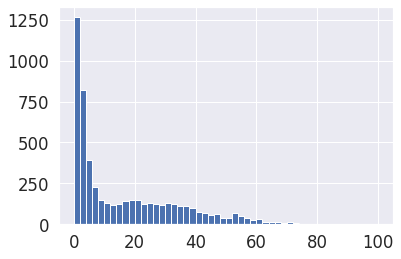

In [0]:
debate['speaking_time_seconds'].hist(bins=50, range=(0,100))
plt.show()

In [0]:
print(debate['debate_name'].value_counts())
print('\n')
print(debate['debate_section'].value_counts())
print('\n')
print(debate['speaker'].value_counts().head(10))

# On a 10 débats différents, donc 2 qui s'étalent sur 2 nuits différentes
# Michael Bloomberg s'est moins exprimé que d'autres candidats ayant gagné moins voir aucun délégué car il est entré en campagne plus tard
# Des candidats peuvent s'être exprimé beaucoup et ne pas avoir de délégués (peu connus) car ils se sont retirés tot

October Democratic Debate Transcript: 4th Debate in Ohio                                  647
Transcript of July Democratic Debate 2nd Round Night 1: Full Transcript July 30, 2019     644
Transcript from Night 2 of the First 2019 June Democratic Debates                         617
South Carolina Democratic Debate Transcript: February 25 Democratic Debate                578
Transcript of July Democratic Debate 2nd Round, Night 2: Full Transcript July 31, 2019    542
Democratic Debate Transcript: Las Vegas, Nevada Debate                                    523
Transcript from Night 1 of the 2019 June Democratic Debates                               490
September Houston Democratic Debate Transcript – Third Debate                             453
December Democratic Debate Transcript: Sixth Debate from Los Angeles                      385
November Democratic Debate Transcript – 5th Debate Transcript from Atlanta                362
January Iowa Democratic Debate Transcript                   

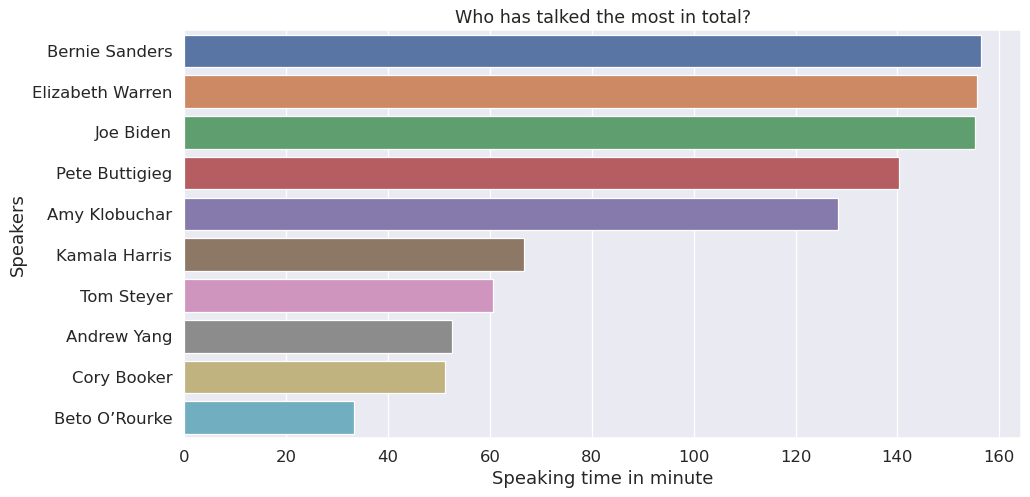

In [0]:
plt.figure(figsize=(12,6), dpi=90)
mostlongspeech=debate.groupby('speaker')['speaking_time_seconds'].sum()
top_speaker= mostlongspeech.sort_values(ascending=False)[:10]
sns.barplot(y=top_speaker.index,x=(top_speaker/60))
plt.title('Who has talked the most in total?',fontsize=14)
plt.ylabel('Speakers')
plt.xlabel('Speaking time in minute')
plt.show()

On crée des indicatrices pour différencier les candidats des journalistes et différencier les candidats importants ou les candidats suffisamment bien représentés dans la base de données (ceux qui ont participé à beaucoup de débats et qui ont souvent pris la parole).

In [0]:
# ensemble des candidats déclarés
candidats_decla = ['Joe Biden', 'Elizabeth Warren', 'Bernie Sanders', 'Pete Buttigieg', 'Amy Klobuchar', 'Kamala Harris', 'Cory Booker',
              'Michael Bloomberg', 'Tulsi Gabbard', 'Tom Steyer', 'Beto O’Rourke', 'Andrew Yang', 'Julian Castro', 'John Delaney ',
              'Kirsten Gillibrand', 'Bill de Blasio', 'Tim Ryan', 'Marianne Williamson', 'Michael Bennet', 'Steve Bullock',
              'Jay Inslee', 'Eric Swalwell'] 

# candidats encore en course lors du début officiel des primaires (3 février 2020)
candidats_ofi = ['Joe Biden', 'Elizabeth Warren', 'Bernie Sanders', 'Pete Buttigieg', 'Amy Klobuchar', 'Michael Bloomberg', 
                 'Tulsi Gabbard', 'Tom Steyer', 'Andrew Yang', 'Michael Bennet'] 

# candidats principaux (voix récoltées > 1M et statut médiatique)
candidats_princ = ['Joe Biden', 'Elizabeth Warren', 'Bernie Sanders', 'Michael Bloomberg'] 

# candidats les mieux représentés dans la base de données
candidats_repr = ['Joe Biden', 'Elizabeth Warren', 'Bernie Sanders', 'Pete Buttigieg', 'Amy Klobuchar']

In [0]:
# Des candidats plus ou moins importants et des journalistes s'expriment dans les débats, on crée une indicatrice pour les différencier
debate['candidats_decla'] = np.where(debate['speaker'].isin(candidats_decla),1,0)
debate['candidats_ofi'] = np.where(debate['speaker'].isin(candidats_ofi),1,0)
debate['candidats_princ'] = np.where(debate['speaker'].isin(candidats_princ),1,0)
debate['candidats_repr'] = np.where(debate['speaker'].isin(candidats_repr),1,0)

In [0]:
# Nombre de lignes (prise de parole différente) de candidats, candidats officiels, candidats principaux
print(debate['candidats_decla'].sum() , 
      debate['candidats_ofi'].sum() , 
      debate['candidats_princ'].sum())
# Pourcentage des prises de paroles totales
print(debate['candidats_decla'].sum()/len(debate) , 
      debate['candidats_ofi'].sum()/len(debate) , 
      debate['candidats_princ'].sum()/len(debate))

3384 2539 1423
0.5724919641346642 0.42953814921333106 0.2407376078497716


In [0]:
debate['speech'][5], debate['speaker'][5]

('Well, you’re right, the economy is doing really great for people like Mr. Bloomberg and other billionaires. In the last three years, last three years, billionaires in this country saw an $850 billion increase in their wealth. But you know what, for the ordinary American things are not so good. Last year, real wage increases for the average worker were less than one percent. Half of our people are living paycheck to paycheck. 87 million Americans have no health insurance or are under-insured. 45 million people are struggling with student debt. 500,000 people tonight are sleeping out on the street, including 30,000 veterans. That is not an economy that’s working for the American people. That’s an economy working for the one percent. We’re going to create an economy for all, not just wealthy campaign contributors.',
 'Bernie Sanders')

In [0]:
print('Il y a {} discours indentiques'.format(debate.duplicated('speech').sum()))
# Expressions basiques qui ont pu être répétées ?

Il y a 544 discours indentiques


In [0]:
debate[(debate.duplicated('speech'))].head(10)
# Yes, No, Thank you composent la majorité de ces doublons

,date,debate_name,debate_section,speaker,speech,speaking_time_seconds,candidats_decla,candidats_ofi,candidats_princ,candidats_repr
49,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,"Thank you, Mayor.",0.0,0,0,0,0
57,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,Senator-,0.0,0,0,0,0
85,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,"Thank you, Senator.",2.0,0,0,0,0
130,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Bernie Sanders,Thank you.,0.0,1,1,1,1
164,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Bernie Sanders,Let’s talk about math!,0.0,1,1,1,1
182,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,Thank you Mr. Steyer.,1.0,0,0,0,0
195,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,"Vice President Biden, please.",1.0,0,0,0,0
210,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,Thank you.,1.0,0,0,0,0
212,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,Thank you Mr. Steyer.,0.0,0,0,0,0
227,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,Thank you.,0.0,0,0,0,0


In [0]:
# Création d'une variable nombre de mots
debate['n_words'] = debate['speech'].str.split(' ').apply(lambda x: len(x))
print(debate.loc[debate['speaker'].isin(candidats_ofi),'n_words'].describe())
print((debate.loc[debate['speaker'].isin(candidats_ofi),'n_words'] <4).sum())

count    2539.000000
mean       65.132336
std        55.382749
min         1.000000
25%        10.000000
50%        59.000000
75%       106.000000
max       265.000000
Name: n_words, dtype: float64
209


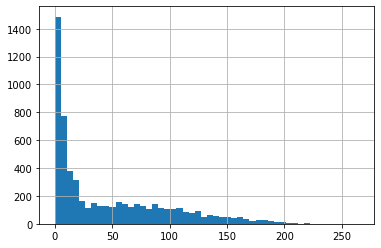

In [0]:
debate['n_words'].hist(bins=50, range=(0,265))
plt.show()

# 2. Preprocessing

In [11]:
#### filtre candidats 
filtre_candidats = candidats_repr

debate_filter = debate[(debate['speaker'].isin(filtre_candidats))].reset_index().copy() 
print("{} observations retirées en conservant {} candidats".format(len(debate) - len(debate_filter), 
                                                                   len(filtre_candidats)))

3840 observations retirées en conservant 5 candidats


In [0]:
# Taille du vocabulaire total
arr = debate_filter.speech.apply(lambda x: x.split(' ')).array
arr = reduce(add, arr) 

print('Il y a {} mots différents dans le corpus.'.format(len(set(arr))))

Il y a 11229 mots différents dans le corpus.


In [0]:
# Comparaison des tokenizers
tokenizers = [TreebankWordTokenizer(), ToktokTokenizer(), TweetTokenizer()]

for tok in tokenizers:
  arr = debate_filter.speech.apply(lambda x: tok.tokenize(x)).array
  arr = reduce(add, arr)
  print("Vocabulary size: {0} with {1} tokenizer".format(len(set(arr)), tok))  

Vocabulary size: 8962 with <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x7fb57f4797f0> tokenizer
Vocabulary size: 8844 with <nltk.tokenize.toktok.ToktokTokenizer object at 0x7fb57f479860> tokenizer
Vocabulary size: 7135 with <nltk.tokenize.casual.TweetTokenizer object at 0x7fb57f479898> tokenizer


### Nettoyage de notre corpus de prise de parole pendant les discours

In [0]:
def clean_corpus(corpus, threshold=100):
  tokenizer = TreebankWordTokenizer()  
  tokenized_sentences = []
  for sample in corpus:
    # we remove sentence split as we need to keep the whole intervention as one
    tokens = tokenizer.tokenize(sample)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokenized_sentences.append(tokens)

  phrases = Phrases(tokenized_sentences, threshold=threshold)
  phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus

In [0]:
clean_speeches = clean_corpus(debate_filter.speech.array)
debate_filter['tokenized_speech'] = pd.Series(clean_speeches)
debate_filter['clean_speech'] = debate_filter['tokenized_speech'].apply(lambda x: ' '.join(x))

### Variable speaker recodée en chiffres

In [14]:
debate_filter['code_speaker'] = debate_filter['speaker'].astype('category').cat.codes
print(debate_filter[['speaker','code_speaker']].drop_duplicates())

             speaker  code_speaker
0     Bernie Sanders             1
2     Pete Buttigieg             4
3   Elizabeth Warren             2
6          Joe Biden             3
21     Amy Klobuchar             0


### Division train/validation/test datasets

In [15]:
# assignation à la base train, validation ou test
debate_filter.loc[debate_filter.index.to_series().sample(frac=0.6, random_state=42).index, 'dataset'] = "train"
debate_filter.loc[debate_filter[debate_filter['dataset'].isna()].index.to_series().sample(frac=0.5, random_state=42).index, 'dataset'] = "test"
debate_filter['dataset'] = debate_filter['dataset'].fillna("validation")
print(debate_filter['dataset'].value_counts(normalize=True))

train         0.600193
validation    0.199903
test          0.199903
Name: dataset, dtype: float64


# 3. Classifications sans embeddings

## Extraction de features


In [0]:
X_train = debate_filter.loc[debate_filter['dataset']=="train", 'clean_speech'].values
X_dev = debate_filter.loc[debate_filter['dataset']=="validation", 'clean_speech'].values
X_test = debate_filter.loc[debate_filter['dataset']=="test", 'clean_speech'].values

y_train = debate_filter.loc[debate_filter['dataset']=="train", 'speaker'].values
y_dev = debate_filter.loc[debate_filter['dataset']=="validation", 'speaker'].values
y_test = debate_filter.loc[debate_filter['dataset']=="test", 'speaker'].values

print(X_train[0])
print(y_train[0])

well , you ’ re right , the economy is doing really great for people like mr._bloomberg and other billionaires. in the last three years , last three years , billionaires in this country saw an $ 850 billion increase in their wealth. but you know what , for the ordinary american things are not so good. last year , real wage increases for the average worker were less than one percent. half of our people are living paycheck to paycheck. 87_million americans have no health insurance or are under-insured. 45 million people are struggling with student debt. 500,000 people tonight are sleeping out on the street , including 30,000 veterans. that is not an economy that ’ s working for the american people. that ’ s an economy working for the one percent. we ’ re going to create an economy for all , not just wealthy campaign contributors .
Bernie Sanders


## Sélection de modèles

In [0]:
cv = TfidfVectorizer(encoding='cp1252')
features = cv.fit_transform(debate_filter['clean_speech'])
label = debate_filter.speaker

In [0]:
models = [
    RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42),
    LinearSVC(random_state=42),
    MultinomialNB(),
    LogisticRegression(random_state=42),
    LGBMClassifier(random_state=42)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, label, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

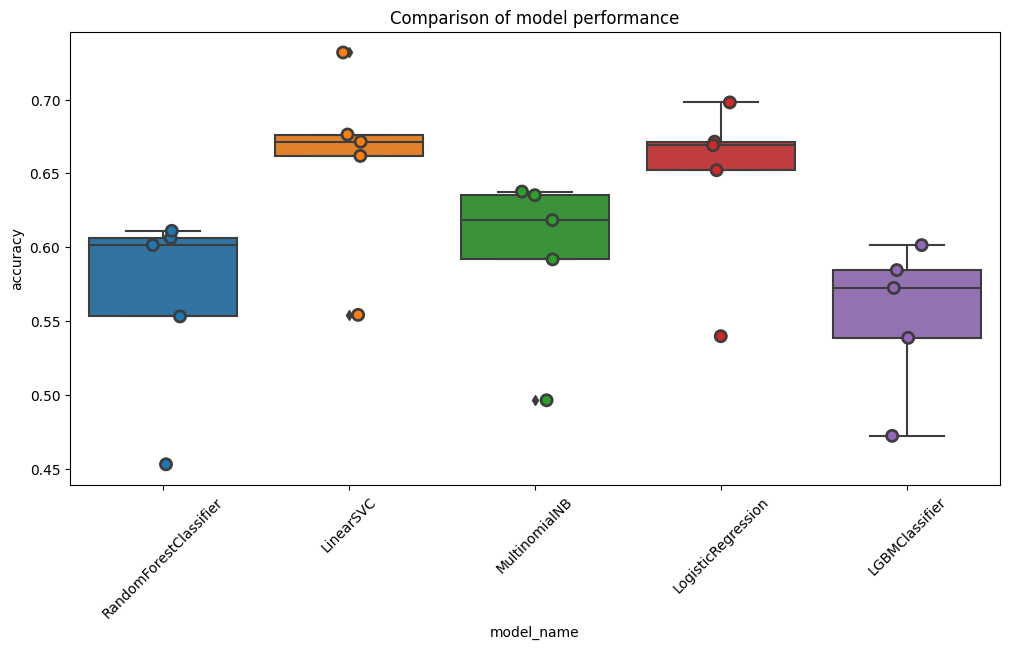

In [0]:
plt.figure(figsize=(12,6), dpi=100)
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)
plt.title('Comparison of model performance')
plt.show()

In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LGBMClassifier            0.553878
LinearSVC                 0.659153
LogisticRegression        0.646116
MultinomialNB             0.595895
RandomForestClassifier    0.564999
Name: accuracy, dtype: float64

Au vu des performances, on choisit le Linear Support Vector Classification que l'on va chercher à optimiser

## Optimisation du SVM

In [0]:
cv = TfidfVectorizer(encoding='cp1252', ngram_range=(1, 2), sublinear_tf=True)
X_train_cv = cv.fit_transform(X_train)
X_dev_cv = cv.transform(X_dev)
X_test_cv = cv.transform(X_test)

In [0]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'tol': [1, 0.1, 0.01, 0.001, 0.0001], 
              'loss': ['hinge','squared_hinge'],
              'multi_class': ['ovr','crammer_singer'],
              'random_state': [42]}  
  
grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train_cv, y_train) 

In [0]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)

In [0]:
svm = LinearSVC(C=1, loss='hinge', multi_class='ovr', tol= 0.0001, random_state=42)
svm.fit(X_train_cv, y_train)
y_pred_svm = svm.predict(X_dev_cv)

## Performance et erreurs du SVM

In [0]:
print(classification_report(y_dev, y_pred_svm))

                  precision    recall  f1-score   support

   Amy Klobuchar       0.73      0.71      0.72        63
  Bernie Sanders       0.74      0.79      0.76        81
Elizabeth Warren       0.78      0.68      0.72        93
       Joe Biden       0.77      0.78      0.77        94
  Pete Buttigieg       0.76      0.82      0.79        83

        accuracy                           0.76       414
       macro avg       0.75      0.76      0.75       414
    weighted avg       0.76      0.76      0.76       414



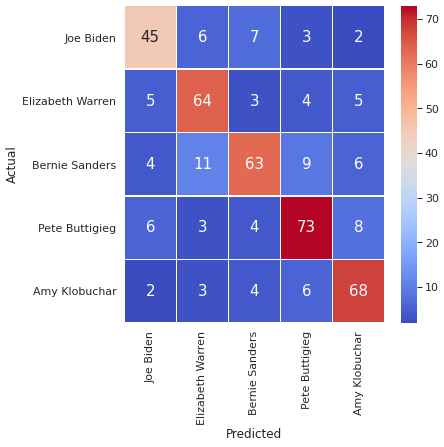

In [0]:
cm = confusion_matrix(y_dev, y_pred_svm) 
labels = candidats_repr
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# config plot sizes
plt.figure(figsize=(7,7), dpi=60)
sns.set(font_scale=1.2)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
i = 0
j = 0
for row_index, (input, prediction, label) in enumerate(zip (X_dev, y_pred_svm, y_dev)):
  if prediction != label:
    i += 1
    if len(X_dev[row_index]) >=25:
      j += 1
      print(X_dev[row_index])
      print('It has been classified as ', prediction, 'and should be ', label)
      print('\n')
print(i, 'bad predictions but only', j, 'for long intervention')

it means equal opportunity , because if we don ’ t pass representative clyburn ’ s bill out of south_carolina here to invest in impoverished communities , we ’ re never going to get to that single garment of destiny .
It has been classified as  Joe Biden and should be  Amy Klobuchar


… i will get voting rights to be a reality for everyone .
It has been classified as  Elizabeth Warren and should be  Amy Klobuchar


… and referred to what i talk about as a “ sideshow. ” this is personal for me. when i was 21 years old , i got my first job as a special education teacher. i loved that job. and by the end of the first year , i was visibly pregnant. the principal wished me luck and gave my job to someone else. pregnancy discrimination ? you bet. but i was 21 years old , i didn ’ t have a union to protect me , and i didn ’ t have any federal law on my side. so i packed up my stuff , and i went home. at least i didn ’ t have a boss who said to me , “ kill it , ” the way that mayor bloomberg-


Sur les 101 mauvaises prédictions, 29 sont des interventions courtes dont il est logiquement difficile d'attribuer un auteur. Nous avons testé de limiter aux interventions de plus de 3 mots mais cela n'augmente pas la précision.

D'autres phrases sont très génériques et il est difficile de les lier à un candidat (ex: i don’t think that’s quite right). 

Certaines prises de parole sont interrompues au milieu d'une phrase lors du débat ce qui gène la prédiction car un mot clef qui aurait du être pronocé ne l'est alors pas (ex : i’m running because so many people-). Cette phrase a été attribuée par erreur à Pete Buttigieg au lieu de Joe Biden sans doute parce qu'il manque l'information clef après so "many people".

Lors de cette intervention en faveur du droit des femmes "Well , my plan as somebody who believes for a start that a woman ’ s right to control her own body is a constitutional right that government and politicians should not infringe on that right. we will do everything we can to defend roe vs wade." l'algorithme avait prédit Elizabeth Warren alors que c'était en fait un homme (Bernie Sanders) qui s'était exprimé.

L'importance du droit des femmes dans les sujets de Bernie Sanders explique peut être cette erreur étonnante lors que cette phrase est attribuée à Bernie Sanders : "so i do think it’s the right question, how do we beat trump? here’s the thing. since donald_trump was elected, women candidates have outperformed men candidates in competitive races. in 2018 , we took back the house. we took back state houses because of women candidates and women voters" alors que c'est une femme qui s'exprime.

Quelques autres erreurs surprenantes apparaissent lors que "senator_sander" est interpellé dans la phrase mais que cette dernière est quand même attribué à Bernie Sanders.

In [0]:
y_pred = svm.predict(X_test_cv)
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

   Amy Klobuchar       0.84      0.76      0.80        68
  Bernie Sanders       0.73      0.72      0.73        83
Elizabeth Warren       0.76      0.80      0.78        96
       Joe Biden       0.76      0.72      0.74        95
  Pete Buttigieg       0.68      0.75      0.72        72

        accuracy                           0.75       414
       macro avg       0.75      0.75      0.75       414
    weighted avg       0.75      0.75      0.75       414



On a 0.75 d'accuracy sur l'échantillon de test

# 4. BERT

Le code de cette partie s'inspire de https://mccormickml.com/2019/07/22/BERT-fine-tuning/ .

In [16]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [17]:
# Load the BERT tokenizer.
print('Loading distilBERT tokenizer...')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

Loading distilBERT tokenizer...


### Mise en forme des données d'input

In [18]:
X_train = debate_filter.loc[debate_filter['dataset']=='train', 'clean_speech'].values
X_val = debate_filter.loc[debate_filter['dataset']=='validation', 'clean_speech'].values
print("{} training samples".format(len(X_train)))
print("{} validation samples".format(len(X_val)))

y_train = debate_filter.loc[debate_filter['dataset']=='train', 'code_speaker'].values
y_val = debate_filter.loc[debate_filter['dataset']=='validation', 'code_speaker'].values

1243 training samples
414 validation samples


In [0]:
# Calcul longueur max des discours pour calibrer la tokenization

def calculate_max_len(input_speeches):
  """
  input as a list of strings
  returns max_len, integer = maximum length among input strings 
  """
  max_len = 0
  
  # For every speech...
  for speech in input_speeches:

      # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
      input_ids = tokenizer.encode(speech, add_special_tokens=True)

      # Update the maximum sentence length.
      max_len = max(max_len, len(input_ids))

  print('Max sentence length: ', max_len)
  return max_len

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

def tokenize_mapping(input_speeches, input_labels):
  """
  input_speeches: list of strings
  input_labels: list of integers = encoded labels 
  returns a tensor dataset
  """

  maximal_length = calculate_max_len(input_speeches)

  input_ids = []
  attention_masks = []

  # For every sentence...
  for speech in input_speeches:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          speech,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = maximal_length,  # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(input_labels)

  # Combine the training inputs into a TensorDataset.
  dataset = TensorDataset(input_ids, attention_masks, labels)

  return dataset


In [21]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

train_dataset = tokenize_mapping(X_train, y_train)

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

val_dataset = tokenize_mapping(X_val, y_val)

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Max sentence length:  282
Max sentence length:  244


In [22]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(filtre_candidats), # The number of output labels 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [0]:
# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Entrainement du modèle

In [27]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device=device, dtype=torch.long)
        b_labels = batch[2].to(device=device, dtype=torch.long)

        # Clear any previously calculated gradients before performing a backward pass. 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        #R eturns the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             #token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. 
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device=device, dtype=torch.long)
        b_labels = batch[2].to(device=device, dtype=torch.long)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   #token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.60
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.28
  Validation Loss: 1.58
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...

  Average training loss: 1.53
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.36
  Validation Loss: 1.50
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...

  Average training loss: 1.41
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.42
  Validation Loss: 1.43
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...

  Average training loss: 1.32
  Training epcoh took: 0:00:17

Running Validation...
  Accuracy: 0.44
  Validation Loss: 1.40
  Validation took: 0:00:02

Training complete!
Total training took 0:01:14 (h:mm:ss)


In [28]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.60,1.58,0.28,0:00:17,0:00:02
2,1.53,1.50,0.36,0:00:17,0:00:02
3,1.41,1.43,0.42,0:00:17,0:00:02
4,1.32,1.40,0.44,0:00:17,0:00:02


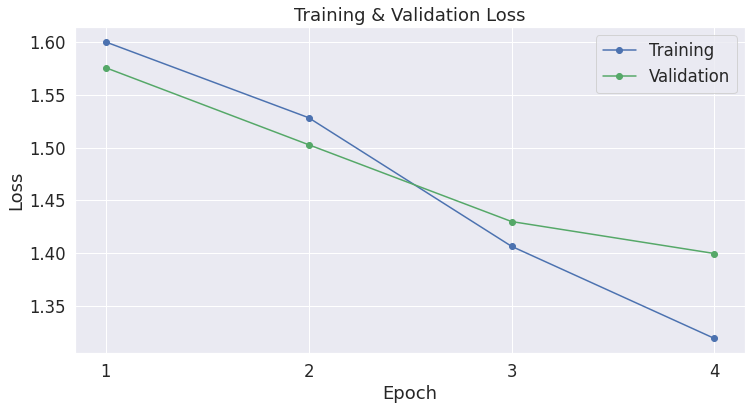

In [29]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

On voit que le modèle commence à être en léger overfit à partir de 4 itérations. Cependant, l'accuracy augmente encore, donc on choisit de ne pas redescendre à trois.

### Evaluation sur le dataset de test

In [30]:
X_test = debate_filter.loc[debate_filter['dataset']=='test', 'clean_speech'].values
print("{} lignes de test".format(len(X_test)))
y_test = debate_filter.loc[debate_filter['dataset']=='test', 'code_speaker'].values

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = tokenize_mapping(X_test, y_test)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

414 lignes de test
Max sentence length:  336


In [31]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []
total_accuracy = 0

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  total_accuracy += flat_accuracy(logits, label_ids)
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    Done')
print("average_accuracy :")
print(total_accuracy/len(prediction_dataloader))

    Done
average_accuracy :
0.48044871794871796


In [32]:
pred = [val for sublist in predictions for val in sublist]
flat_pred = [np.argmax(y).flatten().item() for y in pred]
print(flat_pred)

[1, 3, 1, 3, 3, 2, 4, 4, 4, 3, 3, 3, 0, 1, 3, 1, 2, 3, 4, 2, 3, 4, 4, 4, 4, 1, 2, 1, 1, 0, 1, 0, 1, 3, 3, 0, 0, 0, 3, 3, 1, 3, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 2, 2, 4, 3, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 3, 0, 2, 3, 1, 0, 3, 3, 3, 4, 3, 3, 3, 3, 1, 2, 1, 1, 0, 1, 3, 2, 3, 3, 3, 4, 3, 0, 1, 0, 1, 0, 4, 1, 2, 3, 2, 1, 4, 0, 1, 0, 0, 3, 3, 4, 1, 2, 2, 4, 4, 4, 0, 1, 0, 2, 3, 4, 1, 3, 3, 3, 1, 1, 0, 3, 1, 1, 1, 3, 1, 1, 4, 0, 3, 2, 1, 4, 4, 0, 1, 1, 0, 3, 4, 1, 4, 0, 2, 1, 0, 1, 3, 4, 3, 2, 4, 3, 2, 1, 3, 1, 1, 3, 2, 0, 0, 4, 3, 1, 0, 1, 2, 2, 0, 4, 3, 3, 1, 1, 1, 1, 4, 0, 2, 0, 2, 1, 4, 3, 1, 1, 0, 2, 2, 2, 1, 2, 4, 1, 3, 4, 3, 0, 4, 3, 2, 3, 1, 3, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 3, 1, 3, 0, 1, 1, 3, 0, 0, 1, 4, 1, 4, 3, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 2, 1, 2, 1, 4, 4, 3, 2, 3, 0, 2, 0, 2, 0, 2, 3, 3, 3, 4, 1, 3, 0, 2, 3, 2, 3, 0, 3, 1, 1, 3, 2, 1, 3, 3, 3, 3, 1, 4, 3, 4, 1, 3, 2, 1, 3, 1, 1, 1, 3, 1, 0, 0, 3, 0, 0, 3, 3, 3, 4, 1, 1, 1, 1, 1, 4, 3, 3, 0, 0, 0, 3, 4, 3, 1, 0, 3, 3, 

In [33]:
true_labels_flat = [val for sublist in true_labels for val in sublist]
print(true_labels_flat)

[1, 4, 1, 3, 3, 3, 4, 4, 0, 2, 2, 2, 4, 2, 0, 0, 1, 4, 4, 3, 1, 1, 2, 2, 4, 2, 4, 2, 2, 3, 1, 0, 2, 3, 3, 0, 0, 0, 3, 3, 3, 2, 2, 4, 1, 3, 3, 1, 1, 3, 1, 1, 1, 3, 2, 3, 3, 1, 2, 2, 1, 0, 1, 2, 1, 3, 3, 1, 0, 2, 1, 0, 0, 4, 0, 4, 4, 0, 3, 3, 2, 1, 1, 1, 4, 1, 4, 2, 4, 3, 3, 3, 3, 0, 0, 0, 4, 0, 4, 1, 3, 3, 1, 1, 4, 0, 1, 4, 1, 1, 0, 4, 2, 2, 2, 4, 3, 4, 0, 1, 3, 2, 3, 4, 2, 3, 3, 3, 1, 3, 0, 1, 1, 0, 3, 3, 1, 1, 4, 2, 1, 2, 1, 4, 4, 0, 1, 1, 0, 0, 4, 1, 4, 0, 0, 2, 2, 1, 3, 0, 2, 2, 4, 4, 2, 2, 2, 2, 1, 3, 2, 0, 0, 4, 3, 4, 3, 2, 0, 2, 0, 0, 3, 3, 3, 2, 2, 2, 4, 0, 4, 4, 2, 4, 2, 1, 1, 3, 3, 4, 1, 1, 1, 0, 4, 2, 2, 2, 3, 3, 4, 3, 0, 1, 1, 2, 4, 2, 0, 1, 3, 2, 2, 4, 0, 0, 0, 0, 0, 3, 3, 1, 3, 0, 2, 4, 3, 0, 2, 4, 4, 4, 4, 4, 4, 1, 0, 2, 3, 2, 4, 1, 0, 2, 2, 0, 2, 2, 2, 4, 4, 0, 1, 3, 4, 4, 0, 2, 2, 1, 3, 3, 3, 2, 2, 2, 2, 2, 2, 0, 3, 3, 3, 4, 1, 1, 3, 3, 2, 2, 4, 1, 1, 1, 3, 1, 1, 3, 2, 3, 0, 0, 3, 3, 3, 4, 0, 0, 3, 0, 3, 3, 3, 2, 4, 2, 1, 1, 1, 1, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 

In [36]:
print("accuracy : " + str(np.sum(np.asarray(flat_pred) == np.asarray(true_labels_flat)) / len(true_labels_flat)))


accuracy : 0.4806763285024155


In [40]:
print(classification_report(np.asarray(flat_pred), np.asarray(true_labels_flat)))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54        70
           1       0.65      0.40      0.50       134
           2       0.26      0.45      0.33        56
           3       0.57      0.51      0.54       106
           4       0.40      0.60      0.48        48

    accuracy                           0.48       414
   macro avg       0.49      0.50      0.48       414
weighted avg       0.53      0.48      0.49       414



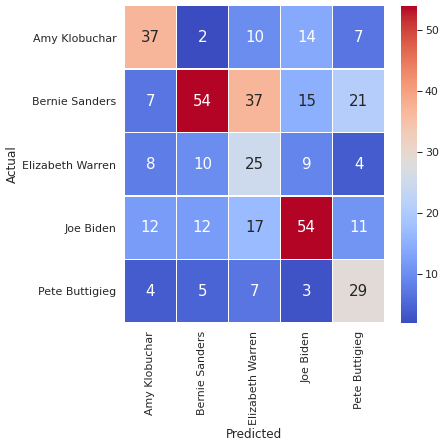

In [45]:
cm = confusion_matrix(np.asarray(flat_pred), np.asarray(true_labels_flat)) 
labels = ['Amy Klobuchar', 'Bernie Sanders','Elizabeth Warren', 'Joe Biden', 'Pete Buttigieg']
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# config plot sizes
plt.figure(figsize=(7,7), dpi=60)
sns.set(font_scale=1.2)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Le modèle a tendance à attribuer faussement des interventions à Elizabeth Warren.

In [44]:
# prises de paroles mal prédites
X_test[(np.asarray(flat_pred) != np.asarray(true_labels_flat))]

array(['let ’ s clear this up once and for all .',
       'i will win south_carolina .',
       'yes , and i think that what we need to do instead of just reviewing everything from the past is talk about where we ’ re going to go forward. martin luther king once said that we are all tied in a single garment of destiny , and that what affects one of us directly affects all of us indirectly. so when there is racism in the criminal_justice system , then we need to fix it. and to me that means sentencing reform , like the first step act , and extending that to the states with the second step act .',
       'he called me out by name in this-', '… is alleged to have said-',
       'oh , i ’ ll be clear .',
       'if you get nominated , we ’ ll be re-litigating this all year .',
       'this is-',
       'no , the math does not add up. in fact , just on 60 minutes this weekend , he said he wasn ’ t going to rattle through the nickels and the dimes. well , let me tell you how many nickels and

Les prises de parole mal attribuées sont souvent des interventions relativement courtes, en particulier des phrases pour lesquelles les speakers ont été interrompus. 

# Annexes : autres recherches conduites sur la base de donées

### Visualisation de la fréquence des mots


In [0]:
corpus = ' '.join(debate['speech'])

In [0]:
stopwords = set(STOPWORDS)
additional_stopwords=('Well','well','will','make','us','we',
                      'I','make','got','need','want','think',
                      'going','go','one','thank','going','didn',
                      'way','see','say','says','still','saying','every','re','us','first',
                     'now','said','know','look','done','take','went',
                     'number','two','three','s','m',"t",'Ye','ask',
                      'let','don','tell','ve','put','maybe','whether','many', 'll','around','thing','Secondly','doesn','lot')
stopwords=stopwords.union(additional_stopwords)

In [0]:
! wget https://www.turnthetownsteal.org/images/turn-the-towns-teal-US-map.jpg

--2020-04-12 20:59:05--  https://www.turnthetownsteal.org/images/turn-the-towns-teal-US-map.jpg
Resolving www.turnthetownsteal.org (www.turnthetownsteal.org)... 162.211.81.190
Connecting to www.turnthetownsteal.org (www.turnthetownsteal.org)|162.211.81.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316516 (309K) [image/jpeg]
Saving to: ‘turn-the-towns-teal-US-map.jpg’

turn-the-towns-teal 100%[===================>] 309.10K  --.-KB/s    in 0.08s   

2020-04-12 20:59:05 (3.60 MB/s) - ‘turn-the-towns-teal-US-map.jpg’ saved [316516/316516]



In [0]:
mask = np.array(Image.open('turn-the-towns-teal-US-map.jpg'))
image_colors = ImageColorGenerator(mask)

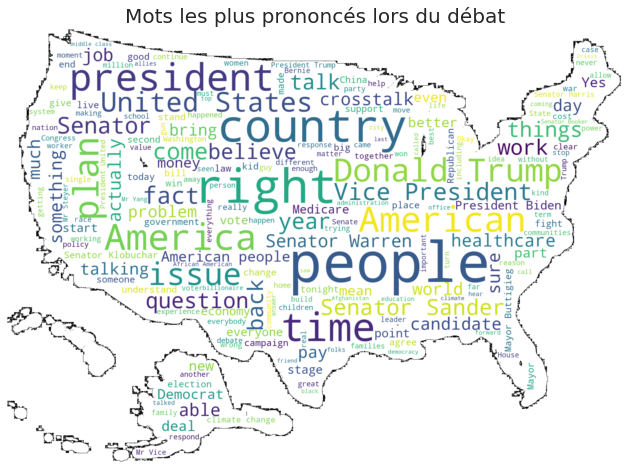

In [0]:
wordcloud = WordCloud(stopwords=stopwords, background_color='white', mask=mask, contour_width=1, contour_color='black').generate(corpus)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Mots les plus prononcés lors du débat', fontsize=20)
plt.show()

In [0]:
#trigrams
trigram = list(trigrams([w for w in word_tokenize(' '.join(debate['speech']).lower()) if 
              (w not in stopwords) & (w.isalpha())]))
tr_fq = FreqDist(bg for bg in trigram)
trdf = pd.DataFrame.from_dict(tr_fq, orient='index', columns=['count'])
trdf.index = trdf.index.map(lambda x: ' '.join(x))
trdf = trdf.sort_values('count',ascending=False)

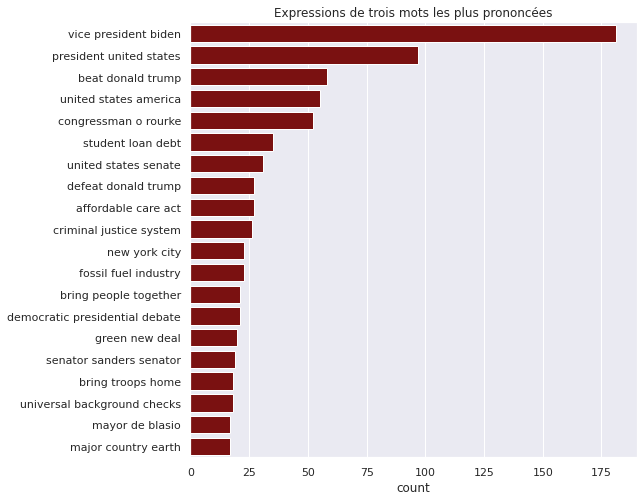

In [0]:
plt.figure(figsize=(8,8))
sns.set(style="darkgrid")
sns.barplot(trdf.head(20)['count'], trdf.index[:20], color='darkred')
plt.title('Expressions de trois mots les plus prononcées')
plt.show()
# Beat Donald Trump apparaît en troisième position

In [0]:
stopwords=stopwords.union(('you.', 'Mr.', 'O', 'yes', 'd'))
punctuation=punctuation + '...' + '’'
to_be_removed = list(stopwords) + list(punctuation)

In [0]:
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def tokenize_sent(corpus):
  tokenizer = TreebankWordTokenizer()  
  tokenized_sentences = []
  for sample in corpus:
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      tokens = list(map(lambda x: x.lower(), tokens))
      tokenized_sentences.append(tokens)
  return tokenized_sentences
  
clean_debate = tokenize_sent(debate.loc[debate['candidats_ofi'] == 1].speech.array)

In [0]:
def show_phrases(tokenized_sentences, threshold=10, shown=15):
  # Training the multi-word expression detector
  phrases = Phrases(tokenized_sentences, threshold=threshold)
  # Represent a score threshold for forming the phrases (higher means fewer phrases). 
  # A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold
  i = 0
  for phrase, score in phrases.export_phrases(tokenized_sentences):
    if i>shown:
      break
    else:
      print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1

In [0]:
# Récupération des bi_gram les plus importants
show_phrases(clean_debate, threshold=100)

Expression : b'mr. bloomberg', score = 183.90166666666667
Expression : b'87 million', score = 240.96305732484078
Expression : b'student debt', score = 234.03154964429325
Expression : b'donald trump', score = 165.30038672329118
Expression : b'vladimir putin', score = 1839.0166666666667
Expression : b'donald trump', score = 165.30038672329118
Expression : b'united states', score = 231.67602378459532
Expression : b'mr. bloomberg', score = 183.90166666666667
Expression : b'united states', score = 231.67602378459532
Expression : b'democratic party', score = 179.63532763532763
Expression : b'wall street', score = 606.4935257121717
Expression : b'bernie sanders', score = 122.10505930767368
Expression : b'donald trump', score = 165.30038672329118
Expression : b'south carolina', score = 936.9615384615385
Expression : b'south bend', score = 636.8888888888889
Expression : b'little bit', score = 565.7706879361915


Pourquoi l'expression 87 millions ? --> Le Scandale Facebook Cambridge Analytica  = fuite de données pour 87M d'utilisateurs

### Topic modelling 

In [0]:
vectorizer_2= CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
vectorized_2 = vectorizer_2.fit_transform(debate['speech'])
lda_model_2 = LatentDirichletAllocation(n_components=10,learning_method='online',verbose=True,random_state=101)
lda_model_fitted_2 = lda_model_2.fit_transform(vectorized_2)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


In [0]:
for index,topic in enumerate(lda_model_2.components_):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer_2.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['want', 'got', 'country', 'just', 'trump', 'need', 'think', 'make', 'going', 'people']


THE TOP 10 WORDS FOR TOPIC #1
['talk', 'country', 'turn', 'trump', 'election', 'let', 'america', 'president', 'united', 'states']


THE TOP 10 WORDS FOR TOPIC #2
['city', 'steyer', 'voters', 'tonight', 'candidates', 'governor', 'democratic', 'debate', 'right', 'new']


THE TOP 10 WORDS FOR TOPIC #3
['care', 'year', 'plan', 'country', 'pay', 'medicare', 'tax', 'insurance', 'people', 'healthcare']


THE TOP 10 WORDS FOR TOPIC #4
['said', 'foreign', 'bring', 'answer', 'running', 'policy', 'seconds', 'want', 'congressman', 'question']


THE TOP 10 WORDS FOR TOPIC #5
['want', 'harris', 'buttigieg', 'response', 'respond', 'warren', 'sanders', 'mayor', 'thank', 'senator']


THE TOP 10 WORDS FOR TOPIC #6
['congress', 'war', 'violence', 'best', 'weapons', 'gun', 'said', 'biden', 'vice', 'president']


THE TOP 10 WORDS FOR TOPIC #7
['crisis', 'new', 'castro', 'problem', 'commun

In [0]:
# A l'aide des 10 mots les plus importants, on essaie de trouver un thème général 
# au cluster
sujets_2= {0:'Country, people',
            1:'Trump, Presidential elections',
            2:'National Security',
            3:'Healthcare, Insurance, Taxes',
            4:'Foreign policies',
            5:'Party Issues, Debate interactions',
            6:'War, Gun Control',
            7:'Politics Issues : climate, community',
            8:'International Relations, Conflicts',
            9:'Immigration, Justice, Rights'}

In [0]:
test = debate.copy()
test['Topic'] = lda_model_fitted_2.argmax(axis=1)
test['Topic'].replace(sujets_2,inplace=True)

topic_top_candidate = test.groupby(['speaker','Topic'])['speech'].count().reset_index()

In [0]:
# Explorer la différence de thèmes entre Sanders, Biden et Warren
bernie_sanders=topic_top_candidate.loc[topic_top_candidate.speaker.isin({'Bernie Sanders'})]
joe_biden=topic_top_candidate.loc[topic_top_candidate.speaker.isin({'Joe Biden'})]
elizabeth_warren=topic_top_candidate.loc[topic_top_candidate.speaker.isin({'Elizabeth Warren'})]

labels_bernie = bernie_sanders['Topic'].values.tolist()
sizes_bernie = bernie_sanders['speech'].values.tolist()

labels_biden = joe_biden['Topic'].values.tolist()
sizes_biden = joe_biden['speech'].values.tolist()

labels_warren = elizabeth_warren['Topic'].values.tolist()
sizes_warren = elizabeth_warren['speech'].values.tolist()

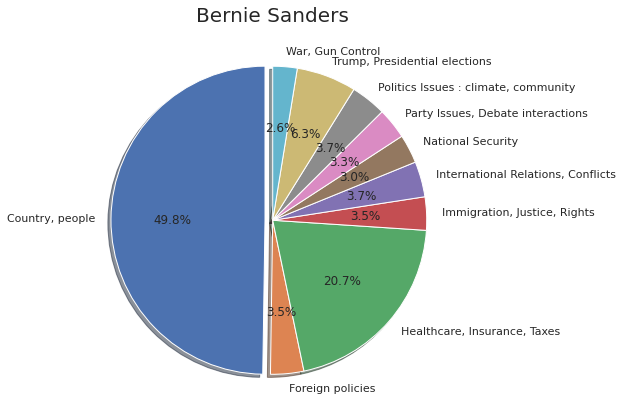

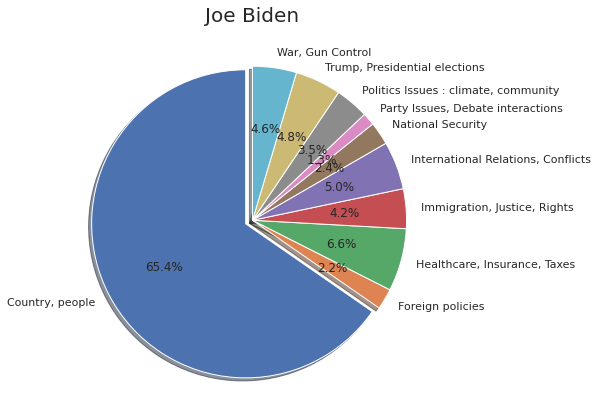

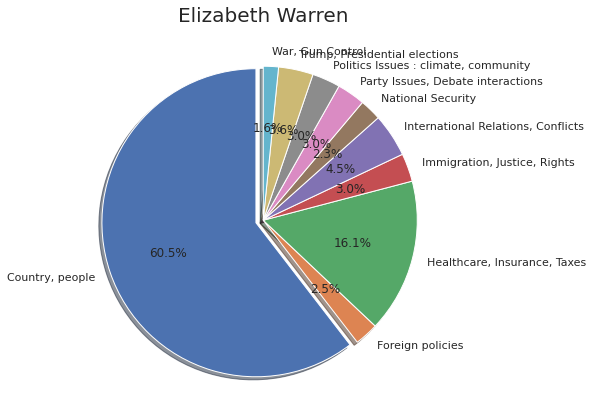

In [0]:
explode = (0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0)  
fig, ax = plt.subplots(figsize=(12,6))

ax.pie(sizes_bernie, explode=explode, labels=labels_bernie, autopct='%1.1f%%', shadow=True, startangle=90)
ax.set_title('Bernie Sanders',fontsize=20)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(12,6))
ax.pie(sizes_biden, explode=explode,labels=labels_biden, autopct='%1.1f%%', shadow=True, startangle=90)
ax.set_title('Joe Biden',fontsize=20)
plt.tight_layout()

fig, ax = plt.subplots(figsize=(12,6))
ax.pie(sizes_warren, explode=explode,labels=labels_warren, autopct='%1.1f%%', shadow=True, startangle=90)
ax.set_title('Elizabeth Warren',fontsize=20)
plt.tight_layout()

plt.show()

Biden s'est peu aventuré sur le sujet de la santé 7% contrairement à Warren 16% et surtout Sanders 21% de ces sujets. Biden est celui qui s'addresse le plus aux citoyens ou à la nation 65%. Est-ce une forme de démagogie ?

### Les similarités par mot et par candidat

In [0]:
# On crée une fonction qui donne les mots les plus similaires à un mot donné
# selon le candidat
def closest_to_for(w, candidates, n=5):
  cleaned_debate = clean_corpus(debate.loc[debate['speaker'] == candidates].speech.array,  threshold = 100)
  cpu = cpu_count()
  deb = Word2Vec(cleaned_debate, size=100, window=5, min_count=3, workers=cpu)
  deb.train(cleaned_debate, total_examples=len(cleaned_debate), epochs=10)
  deb_wv = deb.wv
  wvs = [deb_wv]
  for wv in wvs:
    if w in wv:
      closest_ws =[w[0] for w in wv.most_similar(w, topn=n)]
      print("According to {}, the closest {}, words to \"{}\" " 
        "are: \n {}".format(candidates, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in {} vocabulary".format(candidates))

In [0]:
word = ['healthcare', 'war', 'poverty', 'climate_change']
for w in word:
  for cand in candidats_princ:
    closest_to_for(w, cand)
    print('\n')
  print('========================================================================')

According to Joe Biden, the closest 5, words to "healthcare" are: 
 "does",
 then "drug",
 then "federal",
 then "system",
 then "pass"


According to Elizabeth Warren, the closest 5, words to "healthcare" are: 
 "billionaires",
 then "green",
 then "market",
 then "american",
 then "getting"


According to Bernie Sanders, the closest 5, words to "healthcare" are: 
 "other",
 then "for",
 then "working_class",
 then "as",
 then "which"


healthcare  could not be found in Michael Bloomberg vocabulary


According to Joe Biden, the closest 5, words to "war" are: 
 "without",
 then "north",
 then "in.",
 then "does",
 then "lost"


According to Elizabeth Warren, the closest 5, words to "war" are: 
 "something",
 then "plans",
 then "start",
 then "”",
 then "take"


According to Bernie Sanders, the closest 5, words to "war" are: 
 "has",
 then "terms",
 then "world",
 then "iraq",
 then "today"


According to Michael Bloomberg, the closest 5, words to "war" are: 
 "on",
 then "do",
 then "

Le mot le plus proche de climate change est "everybody" pour Warren (volonté de rassembler ?) et "absolutely" pour Sanders (témoigne de l'urgence). Ce mot n'est pas dans le vocabulaire de Biden et Bloomberg lors de ces débats.

### Train a Word2Vec

In [0]:
cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

print("Training the political W2V ...")
deb = Word2Vec(cleaned_debate, size=100, window=5, min_count=3, workers=cpu)
# size: The number of dimensions of the embeddings.
# window: The maximum distance between a target word and words around the target word.
# min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored.
# workers: The number of partitions during training.
deb.train(cleaned_debate, total_examples=len(cleaned_debate), epochs=10)
deb_wv = deb.wv #word vectors

The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the political W2V ...


In [0]:
domains = ['debate'] 
wvs = [deb_wv]
def closest_to(w, n=10):
  for wv, domain in zip(wvs, domains):
    if w in wv:
      closest_ws =[w[0] for w in wv.most_similar(w, topn=n)]
      print("According to {}, the closest {}, words to \"{}\" " 
      "are: \n {}".format(domain, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the {} vocabulary".format(domain))

#### Examples : annexes


In [0]:
closest_to('planet')
print('========================================================================')
closest_to('climate')
print('========================================================================')
closest_to('green')
print('========================================================================')
closest_to('environment')

According to debate, the closest 10, words to "planet" are: 
 "future",
 then "nation",
 then "democracy",
 then "grandchildren",
 then "enemy",
 then "party",
 then "national",
 then "board",
 then "spectrum",
 then "tools"
According to debate, the closest 10, words to "climate" are: 
 "crisis",
 then "credibility",
 then "vision",
 then "step",
 then "policy",
 then "climate_change",
 then "focuses",
 then "immigration",
 then "reality",
 then "focus"
According to debate, the closest 10, words to "green" are: 
 "worldwide",
 then "new",
 then "sustainable",
 then "units",
 then "1.2",
 then "development",
 then "fields",
 then "energy",
 then "renewable",
 then "living_wage"
According to debate, the closest 10, words to "environment" are: 
 "grandchildren",
 then "aspirations",
 then "expanding",
 then "overall",
 then "diplomatic",
 then "equality",
 then "measure",
 then "tools",
 then "century",
 then "public_schools"


In [0]:
closest_to('woman')
print('========================================================================')
closest_to('african')
print('========================================================================')
closest_to('health')
print('========================================================================')
closest_to('social')

According to debate, the closest 10, words to "woman" are: 
 "human",
 then "constitutional",
 then "thing",
 then "candidate",
 then "given",
 then "choice",
 then "reality",
 then "privilege",
 then "basic",
 then "improvement"
According to debate, the closest 10, words to "african" are: 
 "average",
 then "native",
 then "consumers",
 then "latino",
 then "overwhelming",
 then "undocumented",
 then "mistakes",
 then "asian",
 then "entrepreneurs",
 then "consent"
According to debate, the closest 10, words to "health" are: 
 "insurance",
 then "children",
 then "current",
 then "african_americans",
 then "students",
 then "11",
 then "poverty",
 then "paid",
 then "under-insured",
 then "loan_debt"
According to debate, the closest 10, words to "social" are: 
 "warfare",
 then "cyber",
 then "escalation",
 then "renewable",
 then "cooperation",
 then "opioid",
 then "related",
 then "armed",
 then "doors",
 then "horrific"


In [0]:
closest_to('economy')
print('========================================================================')
closest_to('crisis')
print('========================================================================')
closest_to('finance')
print('========================================================================')
closest_to('debt')
print('========================================================================')
closest_to('inequality')
print('========================================================================')
closest_to('poverty')

According to debate, the closest 10, words to "economy" are: 
 "future",
 then "party",
 then "democracy",
 then "government",
 then "nation",
 then "planet",
 then "21st_century",
 then "investment",
 then "agenda",
 then "opportunity"
According to debate, the closest 10, words to "crisis" are: 
 "policy",
 then "issue",
 then "greatest",
 then "generation",
 then "argument",
 then "climate",
 then "approach",
 then "conversation",
 then "discussion",
 then "problem"
According to debate, the closest 10, words to "finance" are: 
 "warming",
 then "injustice",
 then "watergate",
 then "australia",
 then "defeating",
 then "completely",
 then "diversity",
 then "fourth",
 then "discrimination",
 then "general"
According to debate, the closest 10, words to "debt" are: 
 "student_loan",
 then "canceling",
 then "creating",
 then "homes",
 then "taxpayer",
 then "giant",
 then "9",
 then "development",
 then "amounts",
 then "loan_debt"
According to debate, the closest 10, words to "inequal

In [0]:
closest_to('war')
print('========================================================================')
closest_to('gun')
print('========================================================================')
closest_to('syria')
print('========================================================================')
closest_to('iraq')

According to debate, the closest 10, words to "war" are: 
 "iraq",
 then "agreement",
 then "regime_change",
 then "iran",
 then "committee",
 then "receipts",
 then "intimidated",
 then "office",
 then "nra",
 then "diplomacy"
According to debate, the closest 10, words to "gun" are: 
 "turnout",
 then "greed",
 then "challenge",
 then "fossil_fuel",
 then "powers",
 then "wars",
 then "grassroots_movement",
 then "material",
 then "nations",
 then "safety"
According to debate, the closest 10, words to "syria" are: 
 "hawaii",
 then "al-qaeda",
 then "oval_office",
 then "engaged",
 then "row",
 then "factories",
 then "addition",
 then "2013",
 then "redlining",
 then "northern"
According to debate, the closest 10, words to "iraq" are: 
 "afghanistan",
 then "office",
 then "oklahoma",
 then "university",
 then "meeting",
 then "war",
 then "committee",
 then "walk",
 then "iowa",
 then "stood"


In [0]:
closest_to('trump')
print('========================================================================')
closest_to('politicians')
print('========================================================================')
closest_to('obama')
print('========================================================================')
closest_to('impeachment')

According to debate, the closest 10, words to "trump" are: 
 "donald_trump",
 then "mr.",
 then "presidency",
 then "nominee",
 then "president",
 then "only",
 then "best",
 then "him",
 then "nra",
 then "defeat_donald"
According to debate, the closest 10, words to "politicians" are: 
 "role",
 then "management",
 then "reproductive",
 then "purity",
 then "exist",
 then "solutions",
 then "urban",
 then "delivering",
 then "toxic",
 then "disgusting"
According to debate, the closest 10, words to "obama" are: 
 "vice",
 then "biden",
 then "corrupt",
 then "grateful",
 then "xi",
 then "becoming",
 then "modern_history",
 then "meant",
 then "obstructed",
 then "defeating"
According to debate, the closest 10, words to "impeachment" are: 
 "constitution",
 then "leverage",
 then "discuss",
 then "knowledge",
 then "perspective",
 then "gift",
 then "immoral",
 then "picture",
 then "litmus_test",
 then "filibuster"
